## 📘 Notebook Overview

A concise, end-to-end demonstration of **retail sales forecasting** using **Python** and **scikit-learn**.  
This notebook walks through a practical forecasting workflow from raw data to interpretable results.

## 🧠 Insights and Conclusions

- Sales growth accelerated noticeably after **February 2020**, suggesting a possible **remodeling or capacity increase inferred from the data**.  
- Forecasts indicate continued moderate growth through **2026**, with strong **December seasonality** each year.  
- Post-2020 model results provide a more accurate view of future performance than models trained on the full pre-2020 dataset.  
- The approach can be generalized to other retail datasets.

**Overall Forecasting Trend**  
Illustrates historical and forecasted sales with both linear and seasonal fits.  
Highlights the 2020 break point and forecast extension through 2026.

<img src="figures/predictive_trend.png" alt="Predictive Trend" width="760">

### Workflow Overview

**Step 1 – Load Raw Sales Data**  
Load the source CSV file, explore data structure, and visualize the raw sales trend.

**Step 2 – Data Pre-Processing**  
Clean the dataset by removing zero-sales months and outliers.  
Define **September 2016** as the starting month, assuming peak sales occur each **December**, and mark the noticeable sales jump in **February 2020**.

**Step 3 – Model Fitting**  
Fit both **linear** and **seasonal** functions on the full dataset, then split into **pre- and post-break** periods for separate fitting.

**Step 4 – Forecast Generation**  
Train predictive models (Linear Regression and seasonal decomposition) using data from **2020-Feb to 2024-Dec** to forecast future sales (2025–2026).  
Perform feature engineering, model evaluation, and iterative forecasting.

**Step 5 – Statistical Sales Summary**  
Summarize historical and forecasted results:  
- Yearly and monthly sales growth rates  
- Predicted increases for **2025 and 2026**  
- December and annual sales comparisons  
- Additional metrics such as average sales, volatility, and peak-month trends  

Designed as a **lightweight, interpretable template** for real-world **demand prediction** and **trend analysis** tasks.


In [45]:
# Load necessary Python libraries
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

### 🧩 Step 1: Load Raw Sales Data

- **Load** the raw CSV file containing historical sales records  
- **Inspect** the data structure — view column names, data types, and row counts  
- **Visualize** the raw sales trend with a quick plot  
  - X-axis: Month  
  - Y-axis: Sales


   month      sales
0    1.0  24.321676
1    2.0  29.212176
2    3.0  33.632435
3    4.0  27.904117
4    5.0  31.633817
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   100 non-null    float64
 1   sales   98 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
None


Text(0.5, 1.0, 'Raw Data: Sales Prediction.csv')

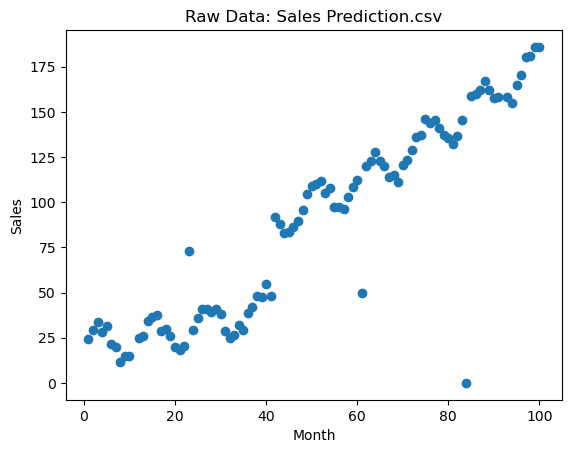

In [25]:
# 1. Load raw sales data from ABC store
df = pd.read_csv("data/Sales Prediction.csv")

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Drop rows where BOTH month and sales are NaN
df = df.dropna(subset=["month", "sales"], how="all").reset_index(drop=True)

# Overview of the raw data
print(df.head())
print(df.info())

# A quick plot
plt.plot(df.month, df.sales, 'o')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Raw Data: Sales Prediction.csv')

### ⚙️ Step 2: Data Pre-Processing Before Modeling

- **Clean** the dataset by removing months with zero sales and obvious outliers  
- **Define** September 2016 as the starting month for the time series, assuming peak sales occur each **December** (this can be adjusted if needed)  
- **Highlight** the sharp sales increase observed in **February 2020**, marked by a vertical red dashed line in the plot


   month      sales       date
0    1.0  24.321676 2016-09-01
1    2.0  29.212176 2016-10-01
2    3.0  33.632435 2016-11-01
3    4.0  27.904117 2016-12-01
4    5.0  31.633817 2017-01-01
    month       sales       date
92   96.0  170.254691 2024-08-01
93   97.0  180.410457 2024-09-01
94   98.0  180.751846 2024-10-01
95   99.0  185.935582 2024-11-01
96  100.0  185.827322 2024-12-01


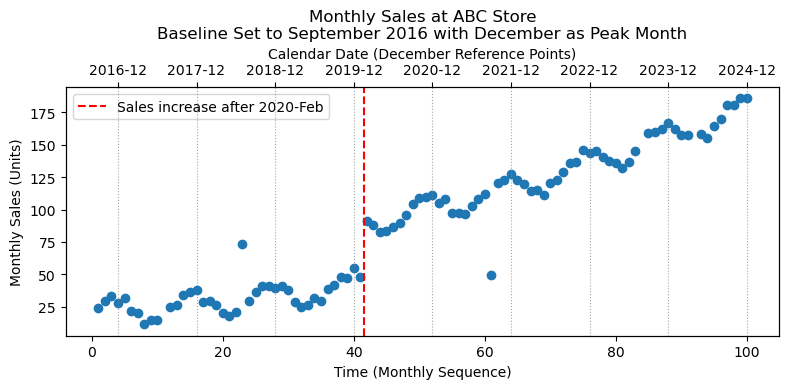

In [26]:
# ---------- remove obvious outliers ----------
# 1) remove zero or negative sales
df = df[df["sales"] > 0].copy()

# 2) remove statistical outliers using IQR
q1 = df["sales"].quantile(0.25)
q3 = df["sales"].quantile(0.75)
iqr = q3 - q1

# this factor (1.5) usually catches "the weird spikes" like the ones in your plot
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df = df[(df["sales"] >= lower_bound) & (df["sales"] <= upper_bound)].copy()


# ---------- Asigned Start Month as 2020-Oct ----------
# "month" is just a running number (1, 2, 3, ...) and we want to start at 2016-Sep to let the peak sale month of the year in December 
start_date = pd.Timestamp("2016-09-01")

# create a proper datetime column based on row position
df["date"] = [start_date + pd.DateOffset(months=int(m - 1)) for m in df["month"]]

# # now we use "date" as the true time index
df = df.sort_values("date").reset_index(drop=True)

# ---------- Overview of the raw data ----------
print(df.head())
print(df.tail())


# ---------- Quick plot of the data ----------
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot sales using the bottom x-axis (month)
ax1.plot(df.month, df.sales, 'o')
ax1.set_xlabel("Time (Monthly Sequence)")
ax1.set_ylabel("Monthly Sales (Units)")
ax1.set_title("Monthly Sales at ABC Store\nBaseline Set to September 2016 with December as Peak Month")

# Create a secondary x-axis on top for date
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())

# Show only December dates on the upper x-axis
december_mask = df.date.dt.month == 12
dec_months = df.month[december_mask]
dec_labels = df.date[december_mask].dt.strftime('%Y-%m')

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Calendar Date (December Reference Points)")
ax2.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

# Add vertical reference line
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5, label='Sales increase after 2020-Feb')
ax1.legend()

plt.tight_layout()
plt.show()

### 📈 Step 3: Fit Data with Linear and Seasonal Models

- **Fit** the entire dataset using both linear and seasonal functions  
- **Split** the data into two segments (pre- and post-break) and **fit each segment separately** to capture structural changes in the trend


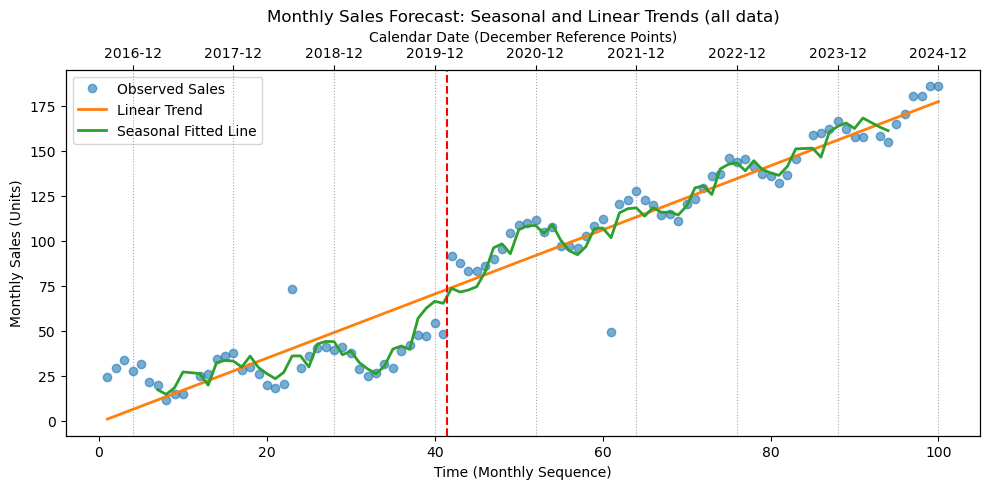

In [27]:
# ---------- Fit the whole data ----------

# Linear regression fit
df2 = df.copy()   # ✅ make a copy before modifying

X = df2["month"].values.reshape(-1, 1)
y = df2["sales"].values
linreg = LinearRegression()
linreg.fit(X, y)
df2["trend_linear"] = linreg.predict(X)

# 3. Seasonal decomposition (using statsmodels)
df2 = df2.set_index("date")
result = seasonal_decompose(df2["sales"], model="additive", period=12)
df2["seasonal_fit"] = result.trend + result.seasonal

# 4. Plot data + linear fit + seasonal fit with two x-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bottom x-axis: month (numeric order)
ax1.plot(df2["month"], df2["sales"], "o", label="Observed Sales", alpha=0.6)
ax1.plot(df2["month"], df2["trend_linear"], "-", label="Linear Trend", linewidth=2)
ax1.plot(df2["month"], df2["seasonal_fit"], "-", label="Seasonal Fitted Line", linewidth=2)
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Time (Monthly Sequence)")
ax1.set_ylabel("Monthly Sales (Units)")
ax1.set_title("Monthly Sales Forecast: Seasonal and Linear Trends (all data)")

# Top x-axis: only December labels
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

december_mask = df2.index.month == 12
dec_months = df2["month"][december_mask]
dec_labels = df2.index[december_mask].strftime("%Y-%m")

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Calendar Date (December Reference Points)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

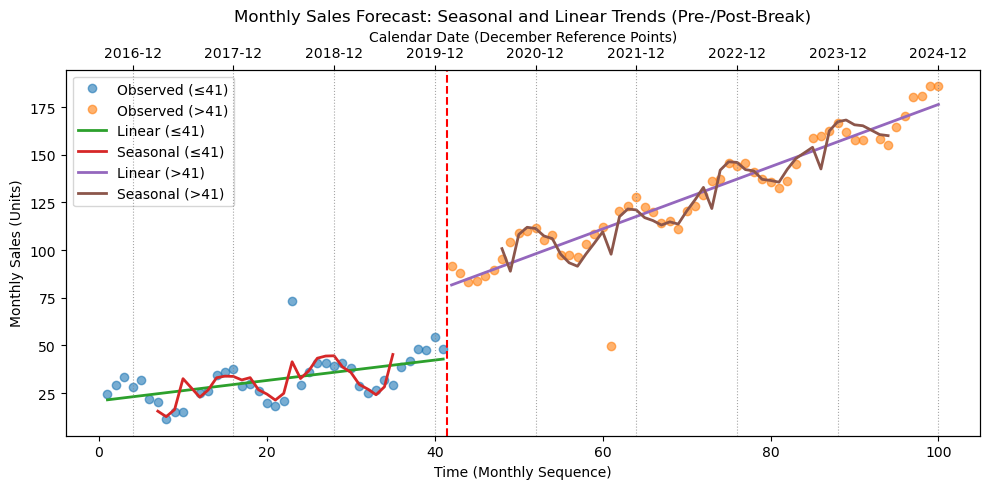

In [28]:
# ---------- Fit by separating data into two portions ----------

# start from the copied version
df2 = df.copy()

# make sure date is indexable later
df2 = df2.sort_values("date").reset_index(drop=True)

# ---------- 1. split into two parts ----------
break_month = 41.5
df2_part1 = df2[df2["month"] <= 41].copy()
df2_part2 = df2[df2["month"] > 41].copy()

# ---------- 2. fit linear + seasonal for part 1 ----------
# linear
X1 = df2_part1["month"].values.reshape(-1, 1)
y1 = df2_part1["sales"].values
lin1 = LinearRegression()
lin1.fit(X1, y1)
df2_part1["trend_linear"] = lin1.predict(X1)

# seasonal: need datetime index
df2_part1_idx = df2_part1.set_index("date")
res1 = seasonal_decompose(df2_part1_idx["sales"], model="additive", period=12)
df2_part1["seasonal_fit"] = (res1.trend + res1.seasonal).values

# ---------- 3. fit linear + seasonal for part 2 ----------
# linear
X2 = df2_part2["month"].values.reshape(-1, 1)
y2 = df2_part2["sales"].values
lin2 = LinearRegression()
lin2.fit(X2, y2)
df2_part2["trend_linear"] = lin2.predict(X2)

# seasonal
df2_part2_idx = df2_part2.set_index("date")
res2 = seasonal_decompose(df2_part2_idx["sales"], model="additive", period=12)
df2_part2["seasonal_fit"] = (res2.trend + res2.seasonal).values

# ---------- 4. plot together with dual x-axes ----------
fig, ax1 = plt.subplots(figsize=(10, 5))

# scatter original points (both parts)
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)

# fitted lines for part 1
ax1.plot(df2_part1["month"], df2_part1["trend_linear"], "-", label="Linear (≤41)", linewidth=2)
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)

# fitted lines for part 2
ax1.plot(df2_part2["month"], df2_part2["trend_linear"], "-", label="Linear (>41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# vertical line to show jump
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

ax1.set_xlabel("Time (Monthly Sequence)")
ax1.set_ylabel("Monthly Sales (Units)")
ax1.set_title("Monthly Sales Forecast: Seasonal and Linear Trends (Pre-/Post-Break)")

# ---------- top x-axis with December only ----------
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

# Use the full df2 for December labels
december_mask = df2["date"].dt.month == 12
dec_months = df2["month"][december_mask]
dec_labels = df2["date"][december_mask].dt.strftime("%Y-%m")

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Calendar Date (December Reference Points)")

ax1.legend(loc="upper left")
plt.tight_layout()
plt.show()

## 🔮 Step 4: Generate Predictive Results

To forecast future sales (2025–2026), only post-February 2020 data (after month 41) is used, focusing on the stable, post-growth trend.

### Process Overview
1. **Post-jump training data** – Restrict model to recent, high-stability period.  
2. **Trend fits** – Compute two linear baselines: overall post-jump and months 42–100.  
3. **Seasonal index** – Derive month-of-year effects from `sales ÷ trend`, smooth and normalize around 1.0.  
4. **Forecast generation** – Extend the trend to 2026 and multiply by the repeated seasonal pattern.  
5. **Visualization** – Plot historical vs fitted vs forecast, highlighting the Feb 2020 break and strong December peaks.

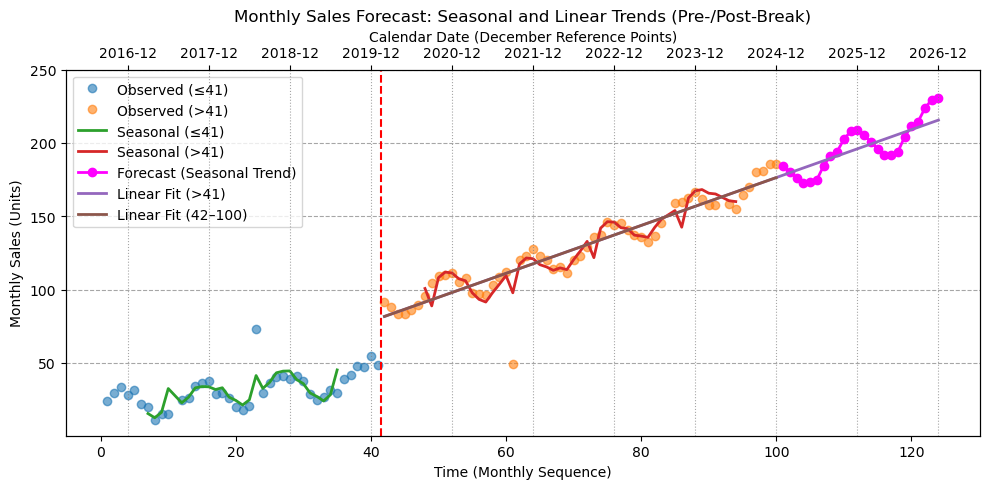

In [46]:
# ---------------------------------------------------------
# 0. BASE DATA
# ---------------------------------------------------------
# We'll base this on df2_part2 (post-jump)
df_post = df2_part2.copy()
period = 12  # monthly seasonality

# ---------------------------------------------------------
# TARGET: forecast until 2026-12
# ---------------------------------------------------------
last_date = df_post["date"].max()
target_end = pd.Timestamp("2026-12-01")
future_steps = (target_end.year - last_date.year) * 12 + (target_end.month - last_date.month)
future_steps = max(future_steps, 1)

last_month = df_post["month"].max()

# ---------------------------------------------------------
# A. LINEAR FIT #1: data > 41 (post-jump)
# ---------------------------------------------------------
x_post = df_post["month"].values
y_post = df_post["sales"].values
lin_slope1, lin_intercept1 = np.polyfit(x_post, y_post, 1)

x_fit1 = np.arange(42, last_month + future_steps + 1)
linear_fit1 = lin_slope1 * x_fit1 + lin_intercept1

# ---------------------------------------------------------
# B. LINEAR FIT #2: data between 42 and 100 months
# ---------------------------------------------------------
mask_42_100 = (df2["month"] >= 42) & (df2["month"] <= 100)
x_42_100 = df2.loc[mask_42_100, "month"].values
y_42_100 = df2.loc[mask_42_100, "sales"].values
lin_slope2, lin_intercept2 = np.polyfit(x_42_100, y_42_100, 1)

x_fit2 = np.arange(42, 100 + 1)
linear_fit2 = lin_slope2 * x_fit2 + lin_intercept2

# ---------------------------------------------------------
# C. IMPROVED SEASONAL FORECAST (MULTIPLICATIVE)
# ---------------------------------------------------------
period = 12  # monthly seasonality

# 1) base series
df_post["month_in_year"] = df_post["date"].dt.month
trend_vals = pd.Series(df_post["trend_linear"]).ffill().bfill().values
sales_vals = df_post["sales"].values

# guard against divide-by-zero in case early trend is 0 or NaN
eps = 1e-6
ratio = sales_vals / (trend_vals + eps)

# 2) build seasonal index by month, recency-weighted
seasonal_index_by_month = (
    df_post.groupby("month_in_year")
    .apply(lambda g: (g["sales"] / (g["trend_linear"] + eps)).ewm(span=3).mean().iloc[-1])
    .sort_index()
)

# this should be around 1.0 on average
# normalize to make the mean exactly 1.0
seasonal_index_cycle = seasonal_index_by_month.values
seasonal_index_cycle = seasonal_index_cycle / seasonal_index_cycle.mean()

# 3) repeat the 12-month seasonal index into the future
seasonal_forecast = np.tile(seasonal_index_cycle, int(np.ceil(future_steps / period)))[:future_steps]

# 4) optional: control seasonal amplitude growth (tunable)
# for multiplicative, this usually stays closer to 1.0,
# but we can blend it toward 1 if we want to damp it over time.
scale_strength = 0   # lower than additive, 0 = no change, 1 = follow trend ratio
trend_ratio = (trend_vals[-1] / trend_vals[0]) if trend_vals[0] != 0 else 1.0
scale_factor = trend_ratio ** scale_strength
seasonal_forecast *= scale_factor ** np.linspace(0, 1, future_steps)

# 5) trend extrapolation (same as before)
slope = (trend_vals[-1] - trend_vals[0]) / (len(trend_vals) - 1)
trend_forecast = trend_vals[-1] + slope * np.arange(1, future_steps + 1)

# 6) combine multiplicatively
forecast_sales = trend_forecast * seasonal_forecast

# 7) pack into df
future_df_seasonal = pd.DataFrame({
    "month": np.arange(last_month + 1, last_month + future_steps + 1),
    "sales": forecast_sales,
    "date": [last_date + pd.DateOffset(months=i) for i in range(1, future_steps + 1)]
})


# ---------------------------------------------------------
# D. PLOT EVERYTHING (aligned with dual x-axes style)
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))

# 1) historical obs
ax1.plot(df2_part1["month"], df2_part1["sales"], "o", label="Observed (≤41)", alpha=0.6)
ax1.plot(df2_part2["month"], df2_part2["sales"], "o", label="Observed (>41)", alpha=0.6)

# 2) historical seasonal fits
ax1.plot(df2_part1["month"], df2_part1["seasonal_fit"], "-", label="Seasonal (≤41)", linewidth=2)
ax1.plot(df2_part2["month"], df2_part2["seasonal_fit"], "-", label="Seasonal (>41)", linewidth=2)

# 3) seasonal forecast (magenta)
ax1.plot(
    future_df_seasonal["month"],
    future_df_seasonal["sales"],
    "o-",
    color="magenta",
    linewidth=2,
    label="Forecast (Seasonal Trend)",
)

# 4) linear fits
ax1.plot(
    x_fit1,
    linear_fit1,
    "-",
    linewidth=2,
    label="Linear Fit (>41)",
)
ax1.plot(
    x_fit2,
    linear_fit2,
    "-",
    linewidth=2,
    label="Linear Fit (42–100)",
)

# 5) vertical split
ax1.axvline(x=41.5, color="red", linestyle="--", linewidth=1.5)

# ---------- Styling and labels ----------
ax1.set_xlabel("Time (Monthly Sequence)")
ax1.set_ylabel("Monthly Sales (Units)")
ax1.set_title("Monthly Sales Forecast: Seasonal and Linear Trends (Pre-/Post-Break)")

# Add horizontal gridlines on specified y-values
ax1.set_yticks([50, 100, 150, 200, 250])
ax1.grid(axis="y", linestyle="--", color="gray", alpha=0.7)

# ---------- Top x-axis (December labels) ----------
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.grid(axis="x", linestyle=":", color="gray", alpha=0.7)

# Use full df2 for historical Decembers
december_mask = df2["date"].dt.month == 12
dec_months = df2["month"][december_mask].tolist()
dec_labels = df2["date"][december_mask].dt.strftime("%Y-%m").tolist()

# Add future Decembers from forecast
future_dec = future_df_seasonal[future_df_seasonal["date"].dt.month == 12]
if not future_dec.empty:
    dec_months.extend(future_dec["month"].tolist())
    dec_labels.extend(future_dec["date"].dt.strftime("%Y-%m").tolist())

ax2.set_xticks(dec_months)
ax2.set_xticklabels(dec_labels)
ax2.set_xlabel("Calendar Date (December Reference Points)")

# ---------- Legend and layout ----------
ax1.legend(loc="upper left")
plt.tight_layout()
plt.savefig("figures/predictive_trend.png", dpi=300, bbox_inches="tight")
plt.show()

### 📊 Step 5: Statistical Sales Summary

This section summarizes both historical and forecasted sales to support business decisions.

- **Monthly and yearly sales increase rate** to understand growth momentum
- **Predicted sales increase rate for 2025 and 2026** based on the forecasted series
- **Predicted sales by year** to see which year outperforms
- **Peak sales month in 2025 and 2026** (usually December, but verified from the forecast)
- **Other useful summaries** such as average monthly sales, volatility, and post-2020 growth behavior


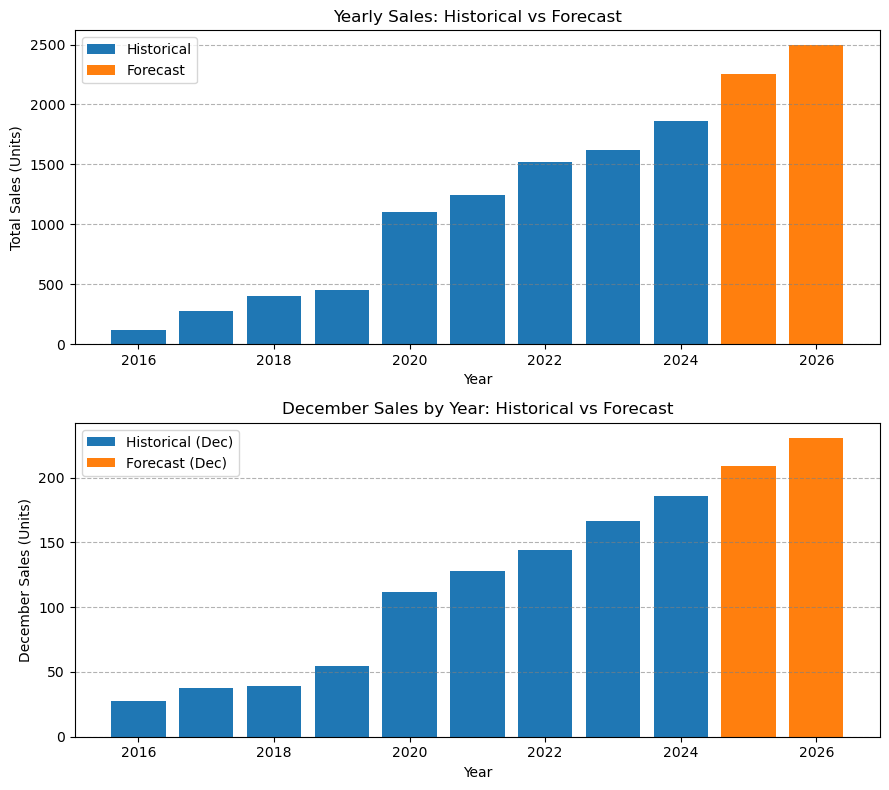

In [47]:
hist_df = df2[["date", "sales"]].copy()
hist_df["source"] = "historical"

future_df = future_df_seasonal[["date", "sales"]].copy()
future_df["source"] = "forecast"

full_df = pd.concat([hist_df, future_df], ignore_index=True)
full_df["year"] = full_df["date"].dt.year
full_df["month_num"] = full_df["date"].dt.month

# ---------------------------------------------------------
# Yearly Sales + December Sales
# ---------------------------------------------------------

# 1) Yearly total sales
yearly = (
    full_df
    .groupby(["year", "source"], as_index=False)["sales"]
    .sum()
    .sort_values("year")
)
yearly["yoy_increase"] = yearly.groupby("source")["sales"].pct_change() * 100

# 2) December-only sales
december_sales = (
    full_df[full_df["date"].dt.month == 12]
    .groupby(["year", "source"], as_index=False)["sales"]
    .sum()
    .sort_values("year")
)

# 3) Create figure with two vertical subplots
plt.figure(figsize=(9, 8))

# --- Top subplot (211): Yearly total sales ---
plt.subplot(211)
for src in ["historical", "forecast"]:
    sub = yearly[yearly["source"] == src]
    plt.bar(sub["year"], sub["sales"], label=src.capitalize())
plt.title("Yearly Sales: Historical vs Forecast")
plt.xlabel("Year")
plt.ylabel("Total Sales (Units)")
plt.legend()
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.6)

# --- Bottom subplot (212): December-only sales ---
plt.subplot(212)
for src in ["historical", "forecast"]:
    sub = december_sales[december_sales["source"] == src]
    plt.bar(sub["year"], sub["sales"], label=f"{src.capitalize()} (Dec)")
plt.title("December Sales by Year: Historical vs Forecast")
plt.xlabel("Year")
plt.ylabel("December Sales (Units)")
plt.legend()
plt.grid(axis="y", linestyle="--", color="gray", alpha=0.6)

# --- Adjust layout ---
plt.tight_layout()
plt.savefig("figures/yearly_december_bars.png", dpi=300, bbox_inches="tight")
plt.show()

In [48]:
# assume full_df has: date, sales, source (historical / forecast)
df_insight = full_df.copy()
df_insight = df_insight.sort_values("date").reset_index(drop=True)

# 1) overall monthly stats
overall_avg = df_insight["sales"].mean()
overall_std = df_insight["sales"].std()
overall_cv = overall_std / overall_avg if overall_avg != 0 else np.nan  # coefficient of variation

# 2) historical vs forecast comparison
hist_df = df_insight[df_insight["source"] == "historical"]
fcst_df = df_insight[df_insight["source"] == "forecast"]

hist_avg = hist_df["sales"].mean()
hist_std = hist_df["sales"].std()
fcst_avg = fcst_df["sales"].mean()
fcst_std = fcst_df["sales"].std()

# 3) post-2020 insight (because you marked 2020-02 as the structural jump)
post_jump_df = df_insight[df_insight["date"] >= "2020-02-01"]
post_jump_avg = post_jump_df["sales"].mean()
post_jump_std = post_jump_df["sales"].std()

# 4) month-of-year pattern (seasonality strength)
mo_y = (
    df_insight
    .assign(month_num=lambda d: d["date"].dt.month)
    .groupby("month_num")["sales"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .sort_values("month_num")
)
mo_y["cv"] = mo_y["std"] / mo_y["mean"]

display(mo_y)

,month_num,mean,std,count,cv
0,1,107.411575,66.716527,10,0.621130
1,2,108.826460,63.452711,10,0.583063
2,3,104.246322,64.026395,10,0.614184
3,4,94.690691,66.298271,9,0.700156
4,5,100.643343,64.950832,10,0.645356
5,6,103.734105,64.478379,10,0.621574
6,7,124.701416,56.109409,9,0.449950
7,8,111.370908,70.544514,9,0.633420
8,9,106.024152,73.510945,11,0.693342
9,10,116.848469,70.851541,11,0.606354


In [49]:
print("===== Sales Insights =====")
print(f"Overall avg monthly sales: {overall_avg:,.2f}")
print(f"Overall monthly volatility (std): {overall_std:,.2f}")
print(f"Overall coefficient of variation (std/mean): {overall_cv:,.3f}")

print("\n--- Historical vs Forecast ---")
print(f"Historical avg monthly sales: {hist_avg:,.2f}")
print(f"Historical volatility (std): {hist_std:,.2f}")
print(f"Forecast avg monthly sales: {fcst_avg:,.2f}")
print(f"Forecast volatility (std): {fcst_std:,.2f}")

print("\n--- Post-2020 period (after remodel / jump) ---")
print(f"Post-2020 avg monthly sales: {post_jump_avg:,.2f}")
print(f"Post-2020 volatility (std): {post_jump_std:,.2f}")
print(f"Lift vs overall: {post_jump_avg - overall_avg:,.2f}")

===== Sales Insights =====
Overall avg monthly sales: 110.21
Overall monthly volatility (std): 65.07
Overall coefficient of variation (std/mean): 0.590

--- Historical vs Forecast ---
Historical avg monthly sales: 88.56
Historical volatility (std): 53.27
Forecast avg monthly sales: 197.68
Forecast volatility (std): 16.98

--- Post-2020 period (after remodel / jump) ---
Post-2020 avg monthly sales: 148.70
Post-2020 volatility (std): 41.77
Lift vs overall: 38.49


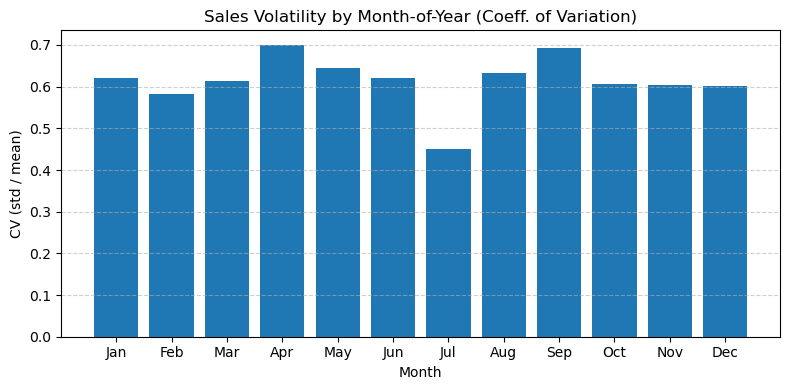

In [52]:
plt.figure(figsize=(8, 4))
plt.bar(mo_y["month_num"], mo_y["cv"])

plt.title("Sales Volatility by Month-of-Year (Coeff. of Variation)")
plt.xlabel("Month")
plt.ylabel("CV (std / mean)")

# Set month labels on x-axis
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(ticks=range(1, 13), labels=month_labels)

plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("figures/sales_volatility_by_month.png", dpi=300, bbox_inches="tight")
plt.show()